### **Packages**

In [ ]:
library(survey)
library(dplyr)
library(haven)
library(tmap)
library(sf)

### **Data**

In [2]:
raw.data <- read_sav("../Vaccine_dropout_mz/Data/IDS_2022_MZKR81FL.SAV")

### **Measles I Recode**

In [3]:
# Measles vaccination status Based on health card recorde with date
raw.data <- raw.data |> 
		mutate(measles = car::recode(H9, 'c(1, 2, 3) = 1;
                               0 = 0;
                               8 = 0'))

count(raw.data, measles)

# A tibble: 3 × 2
  measles                           n
  <dbl+lbl>                     <int>
1  0 [No]                        2668
2  1 [Vaccination date on card]  2722
3 NA                             3899

### **Child's age when recieved vaccination (health card based)**

In [4]:
# Date of vaccination - Moz DHS 2022-23
vaccines_list <- with(raw.data, list(
  list(name = "bcg",     year = H2Y,  month = H2M,  day = H2D),
  list(name = "polio0",  year = H0Y,  month = H0M,  day = H0D),
  list(name = "polio1",   year = H4Y,  month = H4M,  day = H4D),
  list(name = "polio2",   year = H6Y,  month = H6M,  day = H6D),
  list(name = "polio3",   year = H8Y,  month = H8M,  day = H8D),
	list(name = "penta1",  year = H51Y, month = H51M, day = H51D),
  list(name = "penta2",  year = H52Y, month = H52M, day = H52D),
  list(name = "penta3",  year = H53Y, month = H53M, day = H53D),
  list(name = "pcv1",    year = H54Y, month = H54M, day = H54D),
  list(name = "pcv2",    year = H55Y, month = H55M, day = H55D),
  list(name = "pcv3",    year = H56Y, month = H56M, day = H56D),
  list(name = "rota1",   year = H57Y, month = H57M, day = H57D),
  list(name = "rota2",   year = H58Y, month = H58M, day = H58D),
  list(name = "ipv",     year = H60Y, month = H60M, day = H60D),
  list(name = "measles1",year = H9Y,  month = H9M,  day = H9D),
  list(name = "measles2",year = H9AY, month = H9AM, day = H9AD),
  list(name = "vitA1",   year = H33Y, month = H33M, day = H33D)
))


In [5]:
	# Remove unplausible years "9998 [Don't know]"
	fix_year <- function(year){
		return(ifelse(year > 2023, NA, year))
	}

In [6]:
# Create birth date and interview date
birth_and_interview_dates <- function(data){
	data |>
		mutate(
						date_birth = as.Date(ifelse(is.na(fix_year(B2)), NA, paste0(B2,"-",B1,"-",B17))),
						date_interview = as.Date(ifelse(is.na(fix_year(V007)), NA, paste0(V007,"-",V006,"-",V016))),
		)
}

In [7]:
# Compute child's age of vaccination (each vaccine) 
# Compute the variable that indicate whether child vaccinated after 9 months
# 9 months after measles 1 elegible age 
vac_age <- function(data, vac_list){
	
			for(vac in vac_list){
				date_vac = paste0(vac$name, "_date")
 				age_vac = paste0(vac$name, "_age")
				age_vac_after_9 = paste0(vac$name, "_after_9")
				
				data[[date_vac]] = as.Date(ifelse(is.na(fix_year(vac$year)), NA, 
																					paste0(vac$year,"-",vac$month, "-", vac$day)))
				
				data[[age_vac]] = ceiling(unlist(data[date_vac]-data["date_birth"])/30)
				data[age_vac_after_9] = ifelse(data[[age_vac]] >= 9, 1, 0)
			}
	
	data[["vac_after_9"]] <- with(data, ifelse( bcg_after_9 == 1  |
																							polio0_after_9==1 |
																							polio1_after_9==1 |
																							polio2_after_9==1 |
																							polio3_after_9==1 |
																							penta1_after_9==1 |
																							penta2_after_9==1 |
																							penta3_after_9==1 |
																							pcv1_after_9==1   |  
																							pcv2_after_9==1   |  
																							pcv3_after_9==1   |  
																							rota1_after_9==1  | 
																							rota2_after_9==1  | 
																							ipv_after_9==1    |   
																							#measles1_after_9==1 |
																							measles2_after_9==1 |
																							vitA1_after_9==1, 1, 0)  

)
	return(data)
}

### **Recode variables**

In [8]:
recode_variables <- function(ids_data){
  
  ids_data <-  ids_data |>
  mutate(mother_age = car::recode(as.numeric(V013),
                                  "c(1,2)='15-24'; 
                                   c(3,4)='25-34'; 
                                   c(5,6,7,8,9)='≥35'"),
         
  mother_marital_status = car::recode(as.numeric(V501),
                                      "0='Single/Never in union';
                                       c(1,2)='Married/Cohabitation';
                                       3:5='Divorced/Separated/Widowed'"),
  
  mother_education = car::recode(as.numeric(V106),
                                 "0='Illiterate';
                                 1='Primary';
                                 2:3='Secondary/above'"),
  
  mother_occupation = car::recode(as.numeric(V714),
                                  "0='Unemployed';
                                  1='Employed'"),
  
  antenatal_visits = car::recode(as.numeric(M14), 
                                 "0='No visits';
                                 c(1,2,3)='1 to 3'; 
                                 4:15='≥4'"),

  birth_order = car::recode(as.numeric(BORD), 
                            "1='1'; 
                            c(2,3)='2 to 3'; 
                            4:13='≥4' "),
  
  place_of_delivery = car::recode(as.numeric(M15), 
                                  "1:13='At home/Other'; 
                                  14:96='Institutional'"),
  
  has_a_health_card = car::recode(as.numeric(H1), 
                                  "c(0,3)='No'; 
                                  1='Yes seen'; 
                                  2='Yes not seen' "),
    
  has_a_health_card_shrt = car::recode(as.numeric(H1), 
                                  "c(0,3)='No'; 
                                  1:2='Yes'"),

  number_of_household_members = car::recode(as.numeric(V136),
                                            "c(1, 2)='1 to 2';
                                            c(3, 4)='3 to 4';
                                            5:23='≥5'"),
  
  number_of_children_u5h = car::recode(as.numeric(V137), 
                                                            "0='0'; 
                                                            c(1, 2)='1 to 2';
                                                            3:9='≥3' "), 
  
  distance_to_health_facility = car::recode(as.numeric(V467D), 
                                            "0='No problem';
                                            1='Big problem'; 
                                            2='Not a big problem'"),
  
  religion = car::recode(as.numeric(V130), 
                         "1='Catholic'; 
                         2='Islamic'; 
                         3:5='Protestants';
                         c(6)='Others' "),
  
  province = car::recode(as.numeric(V024), 
                       "1='Niassa'; 
                        2='Cabo Delgado'; 
                        3='Nampula'; 
                        4='Zambezia'; 
                        5='Tete'; 
                        6='Manica'; 
                        7='Sofala'; 
                        8='Inhambane'; 
                        9='Gaza'; 
                        10='Maputo'; 
                        11='Maputo City'"),
  
  sex_of_child = as_factor(B4),
  area_of_residence = as_factor(V025),
  wealth_index = as_factor(V190)
  
  ) 
  



# region
ids_data$region[ids_data$V024 < 4] <- "Northern"
ids_data$region[ids_data$V024 > 3 & ids_data$V024 < 8] <- "Central"
ids_data$region[ids_data$V024 > 7] <- "Southern"

# child age
ids_data$age <- ids_data$V008-ids_data$B3

# year
ids_data$year <- 2022


# Factor levels
ids_data$mother_age <- factor(ids_data$mother_age, 
                              level=c('15-24', 
                                      '25-34', 
                                      '≥35'))

ids_data$mother_marital_status <- factor(ids_data$mother_marital_status, 
                                         c("Single/Never in union",
                                           "Married/Cohabitation",  
                                           "Divorced/Separated/Widowed"))

ids_data$mother_education <- factor(ids_data$mother_education, 
                                    levels = c("Illiterate", 
                                               "Primary", 
                                               "Secondary/above"))

ids_data$mother_occupation <- factor(ids_data$mother_occupation, 
                                     levels = c('Unemployed', 
                                                'Employed'))

ids_data$antenatal_visits <- factor(ids_data$antenatal_visits, 
                                    levels = c("No visits",
                                               "1 to 3",
                                               "≥4"))

ids_data$place_of_delivery <- factor(ids_data$place_of_delivery, 
                                     levels = c("At home/Other", 
                                                "Institutional"))

ids_data$birth_order <- factor(ids_data$birth_order, 
                               levels = c("1",
                                          "2 to 3",
                                          "≥4"))

ids_data$has_a_health_card <- factor(ids_data$has_a_health_card, 
                                     levels = c("No", 
                                                "Yes seen", 
                                                "Yes not seen"))


ids_data$has_a_health_card_shrt <- factor(ids_data$has_a_health_card, 
                                     levels = c("No", 
                                                "Yes"))


ids_data$religion <- factor(ids_data$religion, 
                            levels = c("Protestants",
                                       "Catholic", 
                                       "Islamic",
                                       "Others"))

ids_data$region <- factor(ids_data$region, 
                          levels = c("Southern",
                                     "Central", 
                                     "Northern"))

ids_data$number_of_children_u5h <- factor(ids_data$number_of_children_u5h, 
                                                               levels = c("0", 
                                                                          "1 to 2",
                                                                          "≥3"))

ids_data$number_of_household_members <- factor(ids_data$number_of_household_members,
                                               levels = c("1 to 2", 
                                                          "3 to 4", 
                                                          "≥5"))

ids_data$distance_to_health_facility <- factor(ids_data$distance_to_health_facility,
                                               levels = c(#"No problem", 
                                                          "Big problem", 
                                                          "Not a big problem"))

ids_data$province <- factor(ids_data$province, 
                            levels = c("Maputo City",
                                       "Niassa", 
                                       "Cabo Delgado", 
                                       "Nampula", 
                                       "Zambezia",
                                       "Tete", 
                                       "Manica",
                                       "Sofala", 
                                       "Inhambane", 
                                       "Gaza", 
                                       "Maputo"))


return(ids_data)

}

In [9]:
# call 
raw.data_1 <- birth_and_interview_dates(raw.data)

In [10]:
# call
raw.data_2 <- vac_age(data = raw.data_1, vac_list = vaccines_list)

In [ ]:
# call
raw.data_2 <- recode_variables(raw.data_2)

### **Measles MOV**

In [12]:
raw.data_2 <- raw.data_2 |> mutate(mov = ifelse(measles == 0 & vac_after_9 == 1 & H1 == 1, 1, 0))
count(raw.data_2, mov)

# A tibble: 3 × 2
    mov     n
  <dbl> <int>
1     0  3825
2     1   229
3    NA  5235

### **Unweighted measles MOV estimates for under 5 children**

In [14]:
# survey object - simple random sampling
data_unwt <- svydesign(ids = ~1, weights = ~1, data = raw.data_2)

# Estimates
mov <- svyciprop(formula = ~mov, method = "logit", design = data_unwt) 

In [15]:
paste0(round(as.numeric(mov)*100,2), " [", round(attr(mov, "ci")[1] *100, 1), "-", round(attr(mov, "ci")[2] * 100, 2),"]")

[1] "5.65 [5-6.4]"

### **Measles Regional Distributon**

In [ ]:
# MOV by provinces
regions <- svyby(formula = ~mov,by = ~province, FUN=svyciprop, method="beta", na.rm=T, vartype = "ci", design = data_unwt) |>
  as_data_frame() |>
  mutate(mov = mov * 100, 
	ci_l = ci_l * 100,
	ci_u = ci_u * 100)

In [ ]:
# Spatial data
map_data <- read_sf("D:/GIS/Toolkit/Shapes/Moz_admin/moz_admbnda_adm1_ine_20190607.shp")


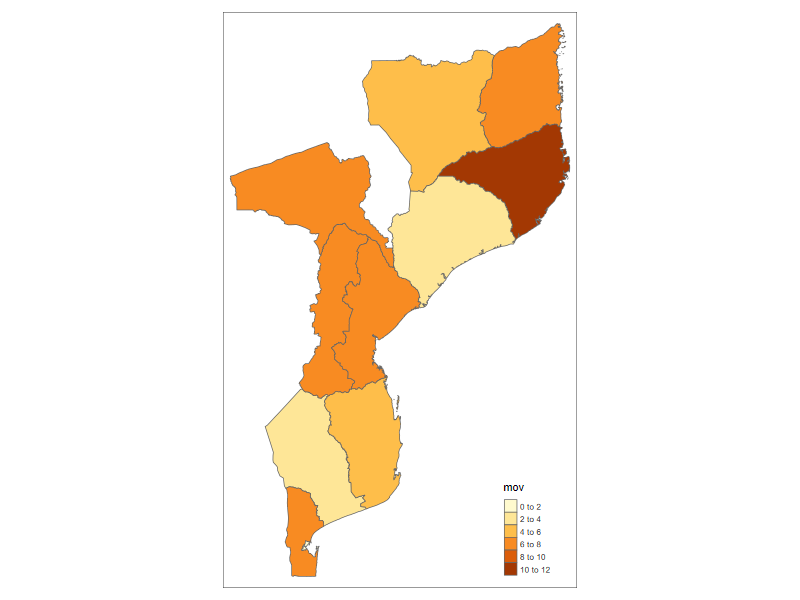

In [ ]:
# Ploting
map_data |> 
	merge(regions, by.x="ADM1_PT", by.y="province")|> 
	tm_shape() +
	tm_polygons(col= "mov")